# **Welcome to *Artificial Alligator's* notebook for the RSNA Lumbar Spine 2024 competition!**


## Table of Contents
...

## Useful links
- [Visual guide to Convolutional Neural Networks](https://www.pinecone.io/learn/series/image-search/cnn/)

- [Youtube video accompaniment to the above guide](https://www.youtube.com/watch?v=ZBfpkepdZlw)

- [Statquest guide to Convolutional Neural Networks](https://www.youtube.com/watch?v=HGwBXDKFk9I)

- [Dicom data preprocessing for Convolutional Neural Networks](https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial#Normalization)

# Library imports and data loading

This section imports the necessary libraries for the following analysis and loads in all the data available to us

In [19]:
import pandas as pd                    # Standard
import numpy as np                     # Standard
import matplotlib.pyplot as plt        # Visualisation
import seaborn as sns                  # Visualisation
import os                              # Directory navigation
import pydicom                         # For working with DICOM medical image data
import shutil
import warnings
import random
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")
path = "../input/rsna-2024-lumbar-spine-degenerative-classification/"              # Base path for the competition
train                     = pd.read_csv(path + "train.csv")                        # Each patient's disease severity and vertebral disk location
train_series_descriptions = pd.read_csv(path + "train_series_descriptions.csv")    # Labelled images' MRI orientation
train_label_coordinates   = pd.read_csv(path + "train_label_coordinates.csv")      # (X,Y) co-ordinates of the centre of the identifying location of the disease on each image
test_series_descriptions  = pd.read_csv(path + "test_series_descriptions.csv")     # Testing images' MRI orientation
sample_submission         = pd.read_csv(path + "sample_submission.csv")            # Sample submission

In [20]:
# Train Data Shape & Missing Values

print(f"Shape of train.csv: {train.shape}")
print(f"No. missing values in train.csv: {train.isna().sum().sum()}")
print("Train head:")
display(train.head())

print(f"Shape of train_label_coordinates.csv: {train_label_coordinates.shape}")
print(f"No. missing values in train_label_coordinates.csv: {train_label_coordinates.isna().sum().sum()}")
print("Train label coordinates head:")
display(train_label_coordinates.head())

print(f"Shape of train_series_descriptions.csv: {train_series_descriptions.shape}")
print(f"No. missing values in train_series_descriptions.csv: {train_series_descriptions.isna().sum().sum()}")
print("Train series descriptions head:")
display(train_series_descriptions.head())

Shape of train.csv: (1975, 26)
No. missing values in train.csv: 572
Train head:


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


Shape of train_label_coordinates.csv: (48692, 7)
No. missing values in train_label_coordinates.csv: 0
Train label coordinates head:


,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


Shape of train_series_descriptions.csv: (6294, 3)
No. missing values in train_series_descriptions.csv: 0
Train series descriptions head:


,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


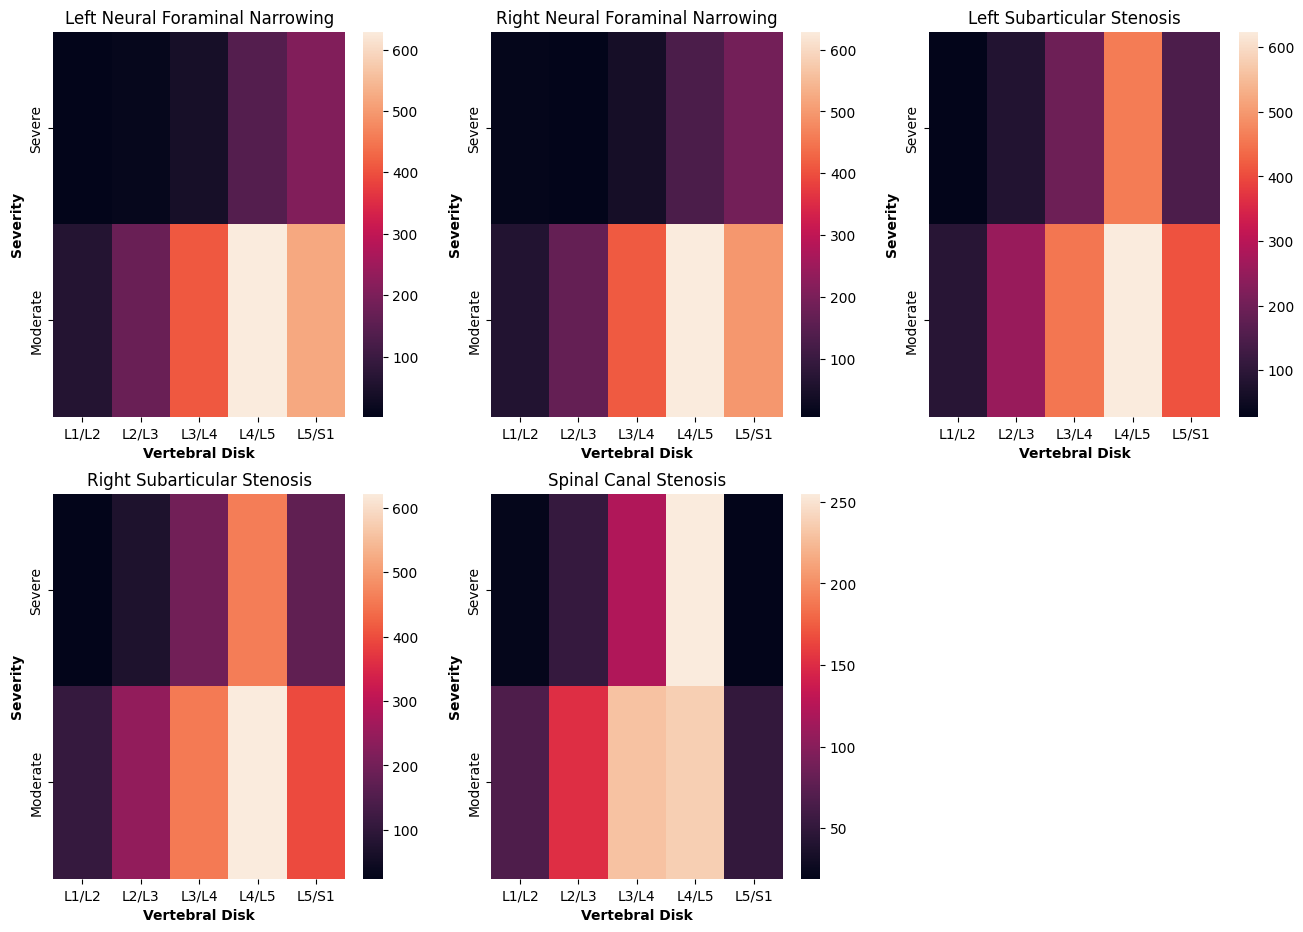

In [21]:
# Where does each disease occur the most?

def heatmapper(df,disease,ax_no_x,ax_no_y):
    columns = [x for x in df.columns if disease in x]
    df = train.loc[:,columns]
    df.columns = [x[-5:].replace('_','/').title() for x in df.columns]
    df = df.apply(lambda x: x.value_counts()).loc[['Severe','Moderate']]
    ax = sns.heatmap(df,ax=axs[ax_no_x,ax_no_y])
    ax.set_title(disease.replace('_',' ').title())
    ax.set_xlabel("Vertebral Disk",fontweight='bold')
    ax.set_ylabel("Severity",fontweight='bold')
    return ax

fig, axs = plt.subplots(2,3,figsize=(16,11))
left_neural = heatmapper(train,'left_neural_foraminal_narrowing',0,0)
right_neural = heatmapper(train,'right_neural_foraminal_narrowing',0,1)
left_subarticular = heatmapper(train,'left_subarticular_stenosis',0,2)
right_subarticular = heatmapper(train,'right_subarticular_stenosis',1,0)
spinal_canal_stenosis = heatmapper(train,'spinal_canal_stenosis',1,1)
axs[1,2].axis('off')
plt.show()

In [22]:
# Dataset join prep, joining, and cleaning

melted_train = pd.melt(train,id_vars='study_id',var_name='condition/location',value_name='severity')
train_label_coordinates['condition/location'] = train_label_coordinates['condition'].str.lower().str.replace(' ','_')  \
                                                + '_' + train_label_coordinates['level'].str.lower().str.replace('/','_')
train_label_coordinates = train_label_coordinates.drop(['condition','level'],axis=1)
train_complete = train_label_coordinates.merge(melted_train,how='left',on=['study_id','condition/location'])
train_complete = train_complete.merge(train_series_descriptions,how='left',on=['study_id','series_id'])
train_complete['location'] = train_complete['condition/location'].str[-5:].str.replace('_','/').str.title()
train_complete['condition'] = train_complete['condition/location'].str[:-6].str.replace('_',' ').str.title()
train_complete = train_complete.drop('condition/location',axis=1)
train_complete = train_complete.reindex(['study_id','series_id','instance_number','x','y','series_description','condition','location','severity'],axis=1)
train_complete.columns = ['study_id','series_id','instance_number','x','y','mri_orientation','condition','location','severity']
train_complete['file_path'] = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/" + train_complete['study_id'].astype('str') + '/' + train_complete['series_id'].astype('str') + '/' + train_complete['instance_number'].astype('str') + '.dcm'
train_complete['mri_orientation'] = train_complete['mri_orientation'].str.replace('/','_')

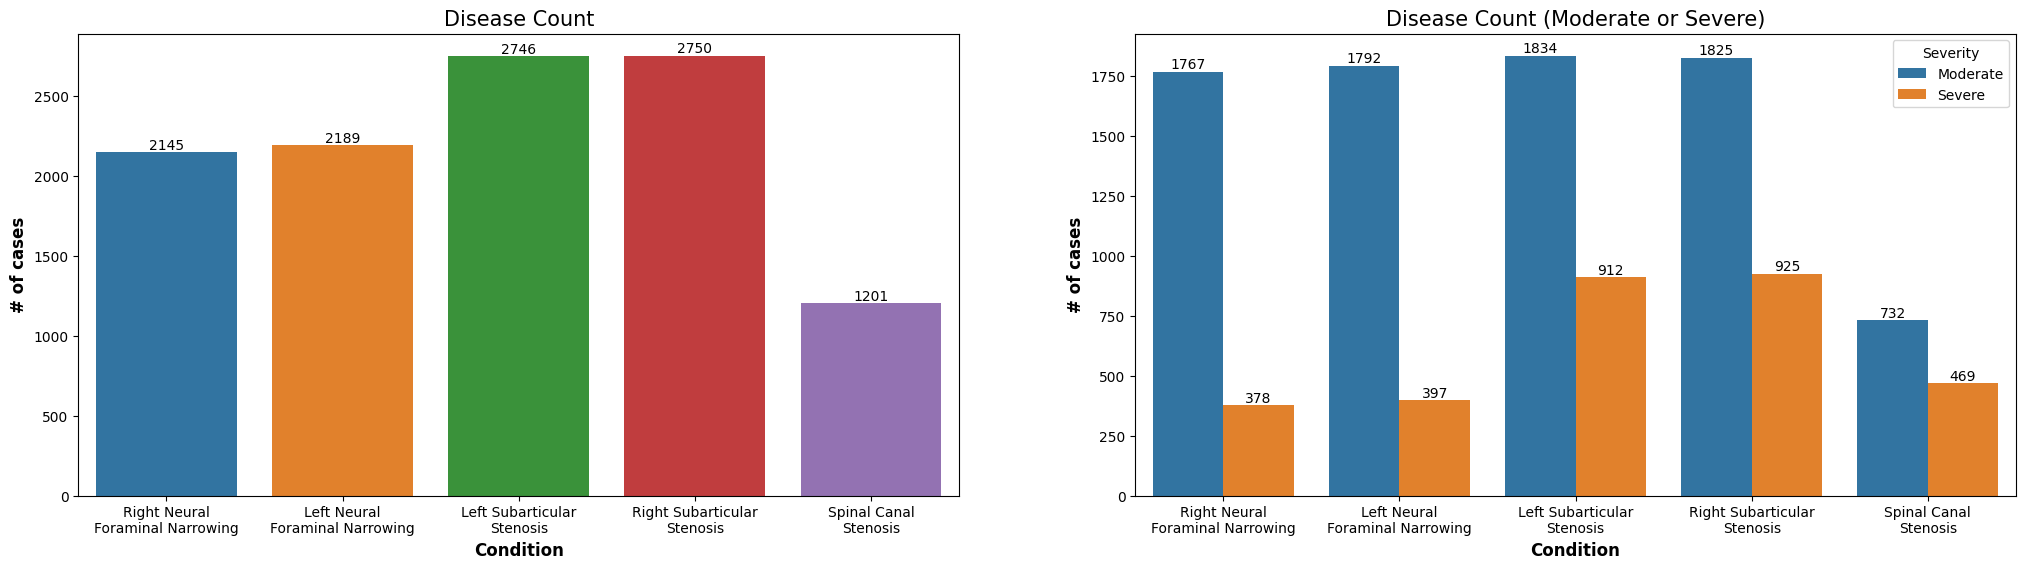

In [23]:
# Which disease occurs the most?

fig, axs = plt.subplots(1,2,figsize=(25,6))
sns.countplot(data=train_complete.loc[(train_complete['severity'] == 'Moderate') | (train_complete['severity'] == 'Severe')],x='condition',ax=axs[0])
x_labels = [x.get_text()[:x.get_text().find(' ',x.get_text().find(' ')+1)] + x.get_text()[x.get_text().find(' ',x.get_text().find(' ')+1):].replace(' ','\n',1) for x in axs[0].get_xticklabels()]
axs[0].set_xticklabels(labels=x_labels)
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel('Condition',fontweight='bold',fontsize=12)
axs[0].set_ylabel('# of cases',fontweight='bold',fontsize=12)
axs[0].set_title('Disease Count',fontsize=15)
sns.countplot(data=train_complete.loc[(train_complete['severity'] == 'Moderate') | (train_complete['severity'] == 'Severe')],x='condition',hue='severity',ax=axs[1])
axs[1].legend(title='Severity')
axs[1].set_xticklabels(labels=x_labels)
axs[1].bar_label(axs[1].containers[0])
axs[1].bar_label(axs[1].containers[1])
axs[1].set_xlabel('Condition',fontweight='bold',fontsize=12)
axs[1].set_ylabel('# of cases',fontweight='bold',fontsize=12)
axs[1].set_title('Disease Count (Moderate or Severe)',fontsize=15)
plt.show()

In [24]:
# Setting baseline probabilities (frequency table) and submission
'''
train_complete['condition_location'] = train_complete['condition'].str.lower().str.replace(' ','_') + '_' + train_complete['location'].str.lower().str.replace('/','_')
freq_table = pd.crosstab(train_complete['condition_location'],train_complete['severity'],normalize='index')
freq_table = freq_table.reset_index()
freq_table = freq_table.reindex(['condition_location','Normal/Mild','Moderate','Severe'],axis=1)
freq_table.columns = ['condition_location','normal_mild','moderate','severe']

submission = pd.DataFrame()

for x in os.listdir("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images"):
    running_df = freq_table.copy()
    running_df['condition_location'] = str(x) + '_' + running_df['condition_location']
    running_df.columns = ['row_id','normal_mild','moderate','severe']
    submission = pd.concat([submission,running_df],axis=0)

train_complete = train_complete.drop('condition_location',axis=1)
'''

'\ntrain_complete[\'condition_location\'] = train_complete[\'condition\'].str.lower().str.replace(\' \',\'_\') + \'_\' + train_complete[\'location\'].str.lower().str.replace(\'/\',\'_\')\nfreq_table = pd.crosstab(train_complete[\'condition_location\'],train_complete[\'severity\'],normalize=\'index\')\nfreq_table = freq_table.reset_index()\nfreq_table = freq_table.reindex([\'condition_location\',\'Normal/Mild\',\'Moderate\',\'Severe\'],axis=1)\nfreq_table.columns = [\'condition_location\',\'normal_mild\',\'moderate\',\'severe\']\n\nsubmission = pd.DataFrame()\n\nfor x in os.listdir("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images"):\n    running_df = freq_table.copy()\n    running_df[\'condition_location\'] = str(x) + \'_\' + running_df[\'condition_location\']\n    running_df.columns = [\'row_id\',\'normal_mild\',\'moderate\',\'severe\']\n    submission = pd.concat([submission,running_df],axis=0)\n\ntrain_complete = train_complete.drop(\'condition_location\'

In [25]:
train = train[train['study_id'] != 3008676218]

orientations = ['Axial T2','Sagittal T1','Sagittal T2_STIR']
st_ids = train['study_id'].unique().tolist()

root = r'/kaggle/working/training_images'
if not os.path.exists(root):
    os.mkdir(root)
else:
    print('Directory already created')
    
for study in st_ids:
    study_path = os.path.join(root,str(study))
    if not os.path.exists(study_path):
        os.mkdir(study_path)
        
    for orient in orientations:
        orient_path = os.path.join(study_path,orient)
        if not os.path.exists(orient_path):
            os.mkdir(orient_path)
        source_paths = train_complete.loc[(train_complete['study_id'] == study) & (train_complete['mri_orientation'] == orient),'file_path'].unique().tolist()
        for source in source_paths:
            dest_filename = source[source.find(str(study))+len(str(study))+1:].replace('/','_')
            dest = os.path.join(orient_path,dest_filename)
            shutil.copy2(source,dest)

Directory already created


In [26]:
def pilify(path):
    pixel_array = pydicom.dcmread(path).pixel_array
    
    if pixel_array.max() > 255:
        normy_pixels = (pixel_array / pixel_array.max()) * 255
    else:
        normy_pixels = pixel_array
    
    normy_pixels = normy_pixels.astype(np.uint8)
    pil = Image.fromarray(normy_pixels)
    
    if pil.mode != 'L':
        pil = pil.convert('L')
    
    return pil

class MRIDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        study_id = row[0]
        labels = torch.tensor(row[1:].values,dtype=torch.float32)
        study_directory = f'/kaggle/working/training_images/{study_id}'
        
        images = []
        
        for root, _, files in os.walk(study_directory):
            for file in files:
                pil_image = pilify(os.path.join(root,file))
                if self.transform:
                    pil_image = self.transform(pil_image)
                images.append(pil_image)
        
        sampled_images = random.sample(images,6)
        images_tensor = torch.stack(sampled_images)
        images_tensor = images_tensor.squeeze(1)
        
        return images_tensor, labels

In [27]:
train = train.fillna(-100)
train = train.replace({'Normal/Mild':0,'Moderate':1,'Severe':2})

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomCrop(size=(200,200)),
    transforms.RandomPerspective(distortion_scale=0.5,p=0.5),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.16767935454845428,std=0.18816058337688446)
])

dataset = MRIDataset(train,transform)

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset,[train_size,validation_size])

train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False,num_workers=4)

In [28]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=6,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv_layer4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv_layer5 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1024*6*6,512)   # no. channels = 1024, height and width are 6 after convolutional layers
        self.relu6 = nn.ReLU()
        
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512,256)
        self.relu7 = nn.ReLU()
        
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256,128)
        self.relu8 = nn.ReLU()
        
        self.fc4 = nn.Linear(128,75)         # output 75 = 25 predictions * 3 possible classes (normal/mild, moderate, severe)
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
        
        out = self.conv_layer3(out)
        out = self.relu3(out)
        out = self.max_pool3(out)
        
        out = self.conv_layer4(out)
        out = self.relu4(out)
        out = self.max_pool4(out)
        
        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
        
        out = out.view(out.size(0),-1)
        
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.relu6(out)
        
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.relu7(out)
        
        out = self.dropout3(out)
        out = self.fc3(out)
        out = self.relu8(out)
        
        out = self.fc4(out)
        
        out = out.view(out.size(0), 25, -1)
        
        return out

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ConvNeuralNet().to(device)
loss_func = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(),lr=0.001)

num_epoch = 50
for epoch in range(num_epoch):
    model.train()
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).long()
        
        outputs = model(images)
        outputs = outputs.view(-1, outputs.size(2))
        labels = labels.view(-1)

        loss = loss_func(outputs,labels)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    with torch.no_grad():
        model.eval()
        
        correct = 0
        total = 0
        all_val_loss = []
        
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).long()
            
            outputs = model(images)
            outputs_reshaped = outputs.view(-1, outputs.size(2))
            labels_reshaped = labels.view(-1)
            
            loss = loss_func(outputs_reshaped,labels_reshaped)
            all_val_loss.append(loss.item())
            
            predicted = torch.argmax(outputs,dim=2)
            correct += (predicted == labels).sum().item()
            
            total += labels.size(0) * labels.size(1)
            
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        mean_val_acc = (correct / total) * 100
        
    print(f"Epoch [{epoch}/{num_epoch}], Last Batch Loss: {loss.item():.4f}, Mean Validation Loss: {mean_val_loss:.4f}, Mean Validation Accuracy: {mean_val_acc:.1f}%")

Loss: 0.5185584425926208
Correct predictions: 1283
Total predictions: 1600
Loss: 0.5877227783203125
Correct predictions: 2511
Total predictions: 3200
Loss: 0.6156084537506104
Correct predictions: 3721
Total predictions: 4800
Loss: 0.6162467002868652
Correct predictions: 4921
Total predictions: 6400
Loss: 0.5647704601287842
Correct predictions: 6170
Total predictions: 8000
Loss: 0.6076160669326782
Correct predictions: 7391
Total predictions: 9600
Loss: 0.5871718525886536
Correct predictions: 7601
Total predictions: 9875
Epoch [0/50], Last Batch Loss: 0.5872, Mean Validation Loss: 0.5854, Mean Validation Accuracy: 77.0%
Loss: 0.5151240229606628
Correct predictions: 1283
Total predictions: 1600
Loss: 0.5765721201896667
Correct predictions: 2511
Total predictions: 3200
Loss: 0.6086108088493347
Correct predictions: 3721
Total predictions: 4800
Loss: 0.6054387092590332
Correct predictions: 4921
Total predictions: 6400
Loss: 0.5602307319641113
Correct predictions: 6170
Total predictions: 8000

KeyboardInterrupt: 